# Program 3.03: Parameter sweep for `adh` using the variable friction model

This program was developed for the master's thesis “Agent-based modelling of embryonic organoid development” (Víctor Villegas-Morral, 2024) using [CellBasedModels.jl](https://github.com/dsb-lab/CellBasedModels.jl).

The report and the rest of the code can be found on the [Multiscale Physics of Living Systems Group’s GitHub](https://github.com/MPoLS-lab) and on [my personal GitHub](https://github.com/villegas-morral/masters-thesis).

## Preamble

In [ ]:
using NBInclude

In [ ]:
@nbinclude("preamble/packages.ipynb");

In [ ]:
@nbinclude("preamble/functions.ipynb");

In [ ]:
model = ABM(3,

	# Global parameters
	model = Dict(
		# Physical constants
		:range => Float64,
		:lambda => Float64,
		:mu => Float64,
		:adh => Array{Float64},
		# Division constants
		:tau_div => Float64,
		:sigma_div => Float64,
		:olap => Float64,
		:g_on => Bool,
		:d_on => Bool,
		:b => Float64,
		:p => Float64,
		:q => Float64,
		:k => Float64,
		# Protrusion parameters
		:fp => Float64,
		:kp_on => Float64,
		:kp_off => Float64,
		# Reference values
		:t0 => Float64,
		:r0 => Float64,
		:f0 => Float64,
		:rep => Float64,
	),


	# Local parameters
	agent = Dict(
		:t_div => Float64,
		:ni => Int64,
		:cell_state => Int64,
		:r => Float64,
		:vx => Float64,
		:vy => Float64,
		:vz => Float64,
		:fx => Float64,
		:fy => Float64,
		:fz => Float64,
		:ni_a => Float64,
		:r_ab => Float64,
		:r_bc => Float64,
		:fpx => Float64,
		:fpy => Float64,
		:fpz => Float64,
		:marked => Bool,
		:t_paired => Float64,
	), 
    
    
    agentODE = quote
		# Physical dynamics
		fx = 0
		fy = 0
		fz = 0
		ni = 0
		@loopOverNeighbors it2 begin
			dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
			if dij < mu * 2 * r && dij > 0
				if dij < 2 * r
					fx += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
					fy += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
					fz += rep * adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				else
					fx += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
					fy += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
					fz += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				end
			end
			if dij < range * 2 * r
				ni += 1
			end
		end
		if marked == true
			if t < t_paired
				fx += fpx
				fy += fpy
				fz += fpz
			else
				marked = false
			end
		end
		lambda_i = lambda
		if ni != 0
			lambda_i *= ni
		end
		vx = fx / lambda_i # if ni = 0 then f = 0 too
		vy = fy / lambda_i
		vz = fz / lambda_i

		dt(x) = vx
		dt(y) = vy
		dt(z) = vz
	end, 
    
    
    agentRule = quote
		# Growth
		if g_on
			if t > t_div
				x_div = CBMDistributions.normal(0, 1)
				y_div = CBMDistributions.normal(0, 1)
				z_div = CBMDistributions.normal(0, 1)
				norm_div = sqrt(x_div^2 + y_div^2 + z_div^2)
				x_div /= norm_div
				y_div /= norm_div
				z_div /= norm_div

				r_sep = r * olap
				@addAgent(
					x = x + r_sep * x_div,
					y = y + r_sep * y_div,
					z = z + r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@addAgent(
					x = x - r_sep * x_div,
					y = y - r_sep * y_div,
					z = z - r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@removeAgent()
			end
		end

		# State evolution
		if d_on == true && cell_state != 3
			ni = 0
			ni_a = 0
			@loopOverNeighbors it2 begin
				dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
				if dij < range * 2 * r
					ni += 1
					if (cell_state[it2] == 1)
						ni_a += 1
					end
				end
			end

			if ni != 0
				ni_a /= ni
			end

			ran = CBMDistributions.uniform(0, 1)

			if cell_state == 1
				r_ab = p / (1 + k * ni_a)
				if ran < r_ab * dt
					cell_state = 2
				end

			elseif cell_state == 2
				r_bc = q / (1 + k * ni_a)
				if ran < r_bc * dt
					cell_state = 3
				end
			end
		end

	end, 
    
    
    agentAlg = CBMIntegrators.Heun(),
);


## Initialization

In [ ]:
parameters = define_par(lambda = 0.1);

dt = 0.002;
save_each = round(Int64, 0.25 / dt);
n_cells = 800;


## Aggregate

In [ ]:
Random.seed!(2345)
reps = [1, 2, 2.5, 3]
ite = length(reps)
coms = Array{Community}(undef, ite);

for i in 1:ite
	com = initialize_growth(parameters; dt)
	com.rep = reps[i]
	grow_size!(com, save_each, n_cells)
	println("$(formed_correctly(com)), N=$(com.N)")
	plot_aggregate(com, color_map, 1, length(com), size  = 8.7)
	coms[i] = com
end

Plot 1: timestamp 1
Plot 2: timestamp 62
Plot 3: timestamp 123
Plot 4: timestamp 185


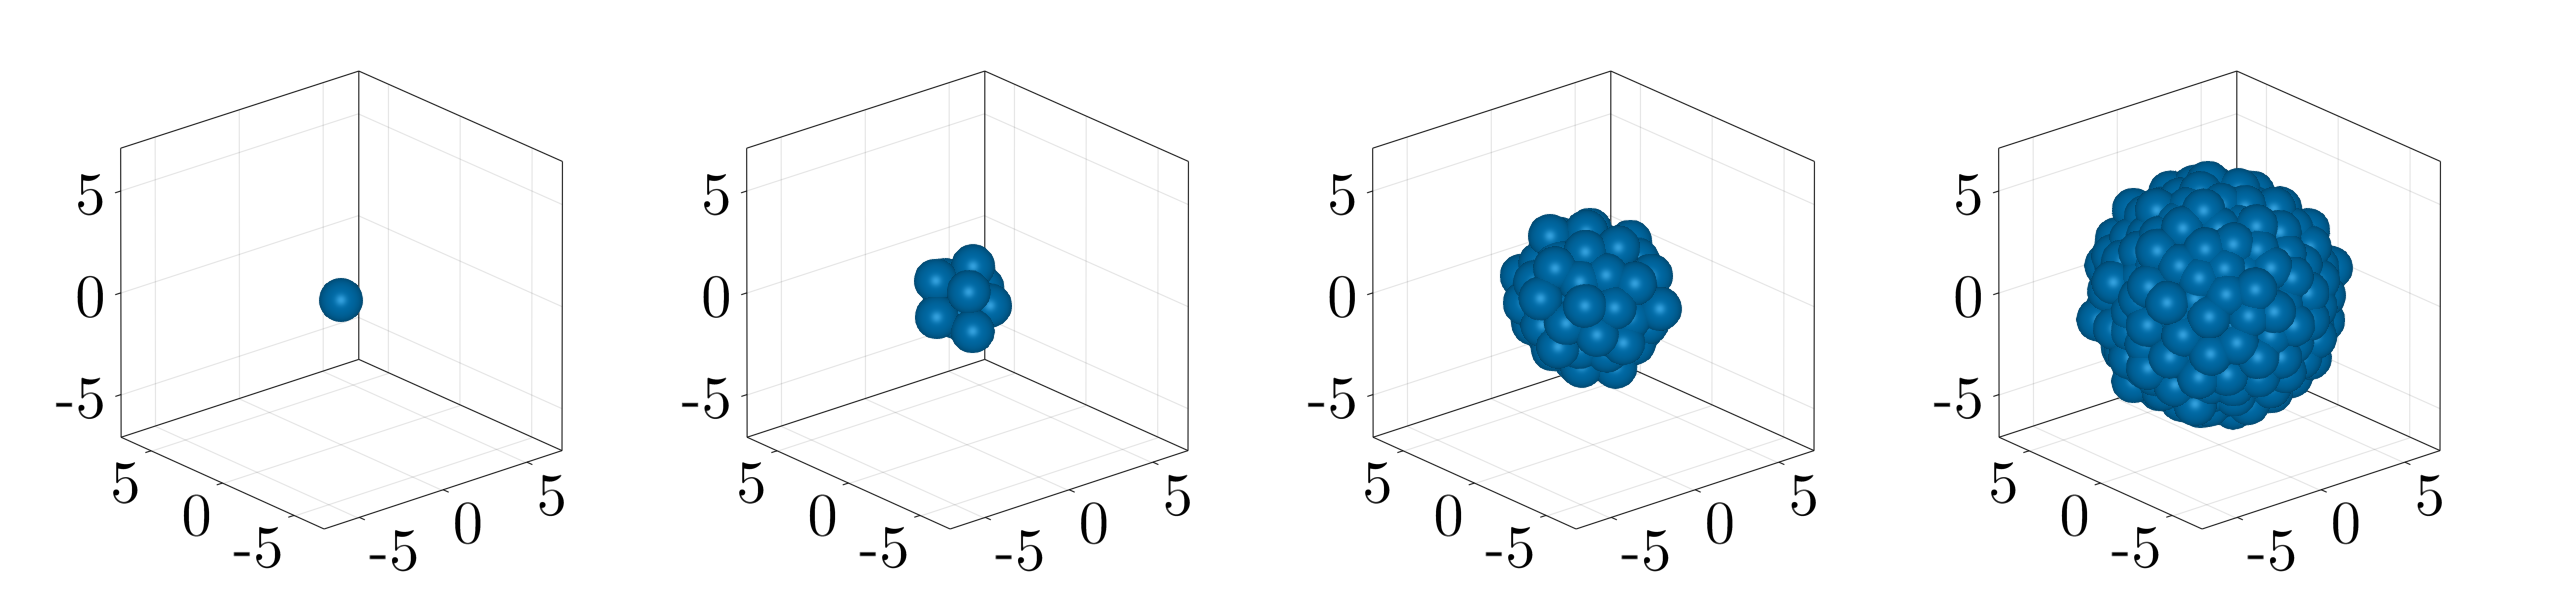

Plot 1: timestamp 1
Plot 2: timestamp 61
Plot 3: timestamp 121
Plot 4: timestamp 182


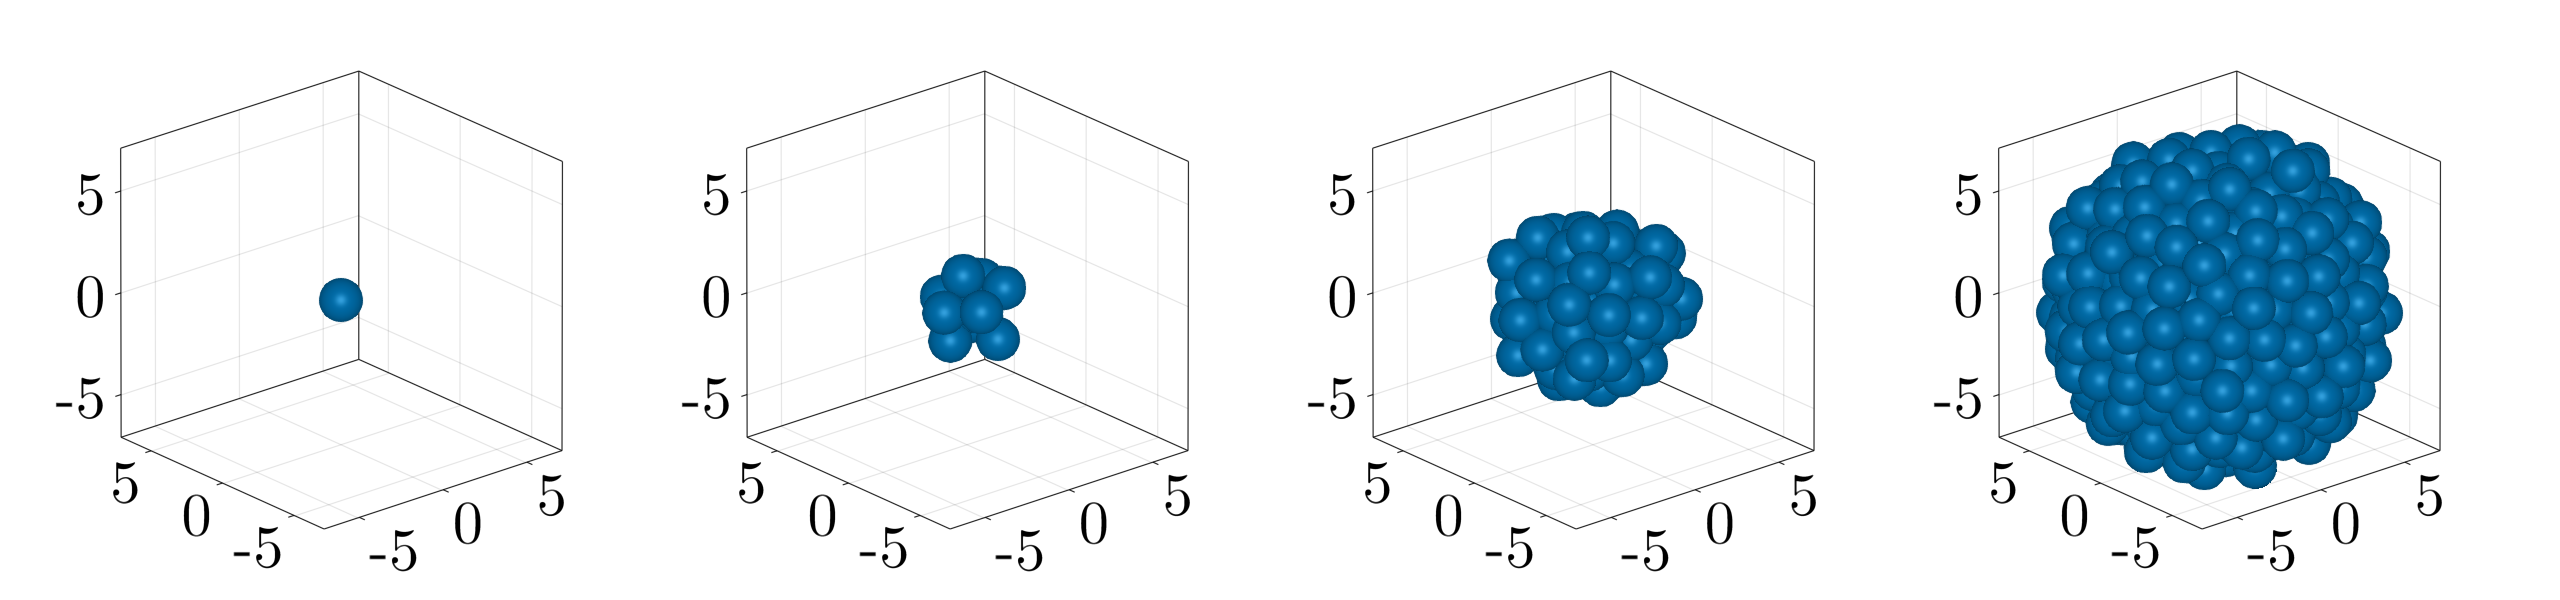

Plot 1: timestamp 1
Plot 2: timestamp 59
Plot 3: timestamp 117
Plot 4: timestamp 176


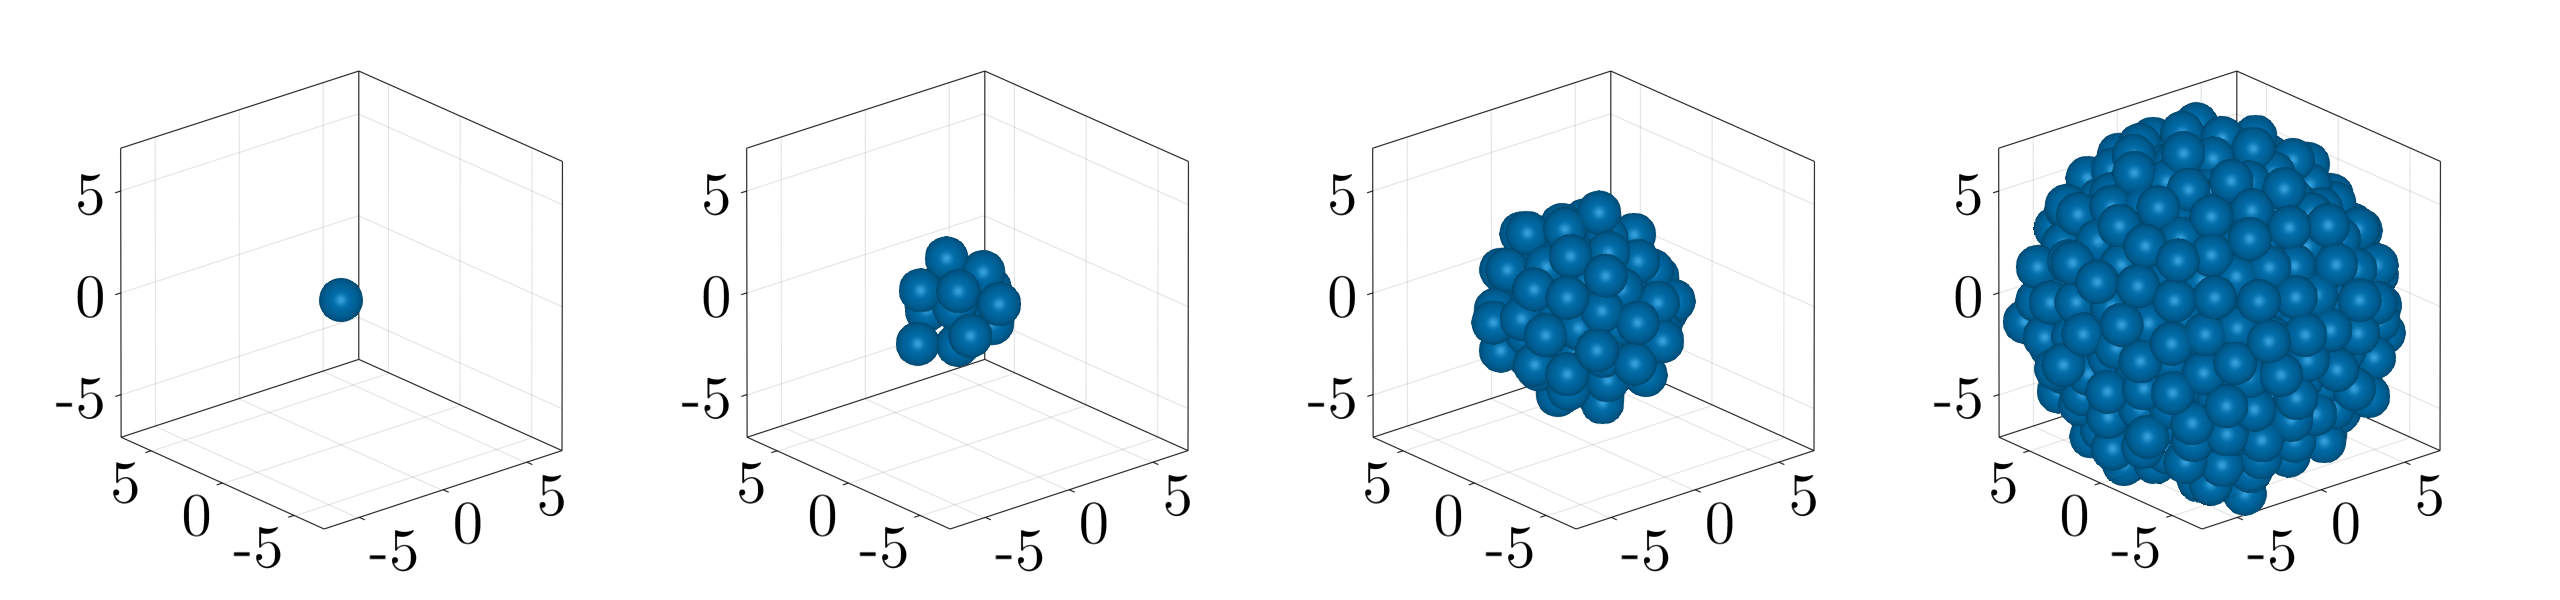

Plot 1: timestamp 1
Plot 2: timestamp 63
Plot 3: timestamp 125
Plot 4: timestamp 187


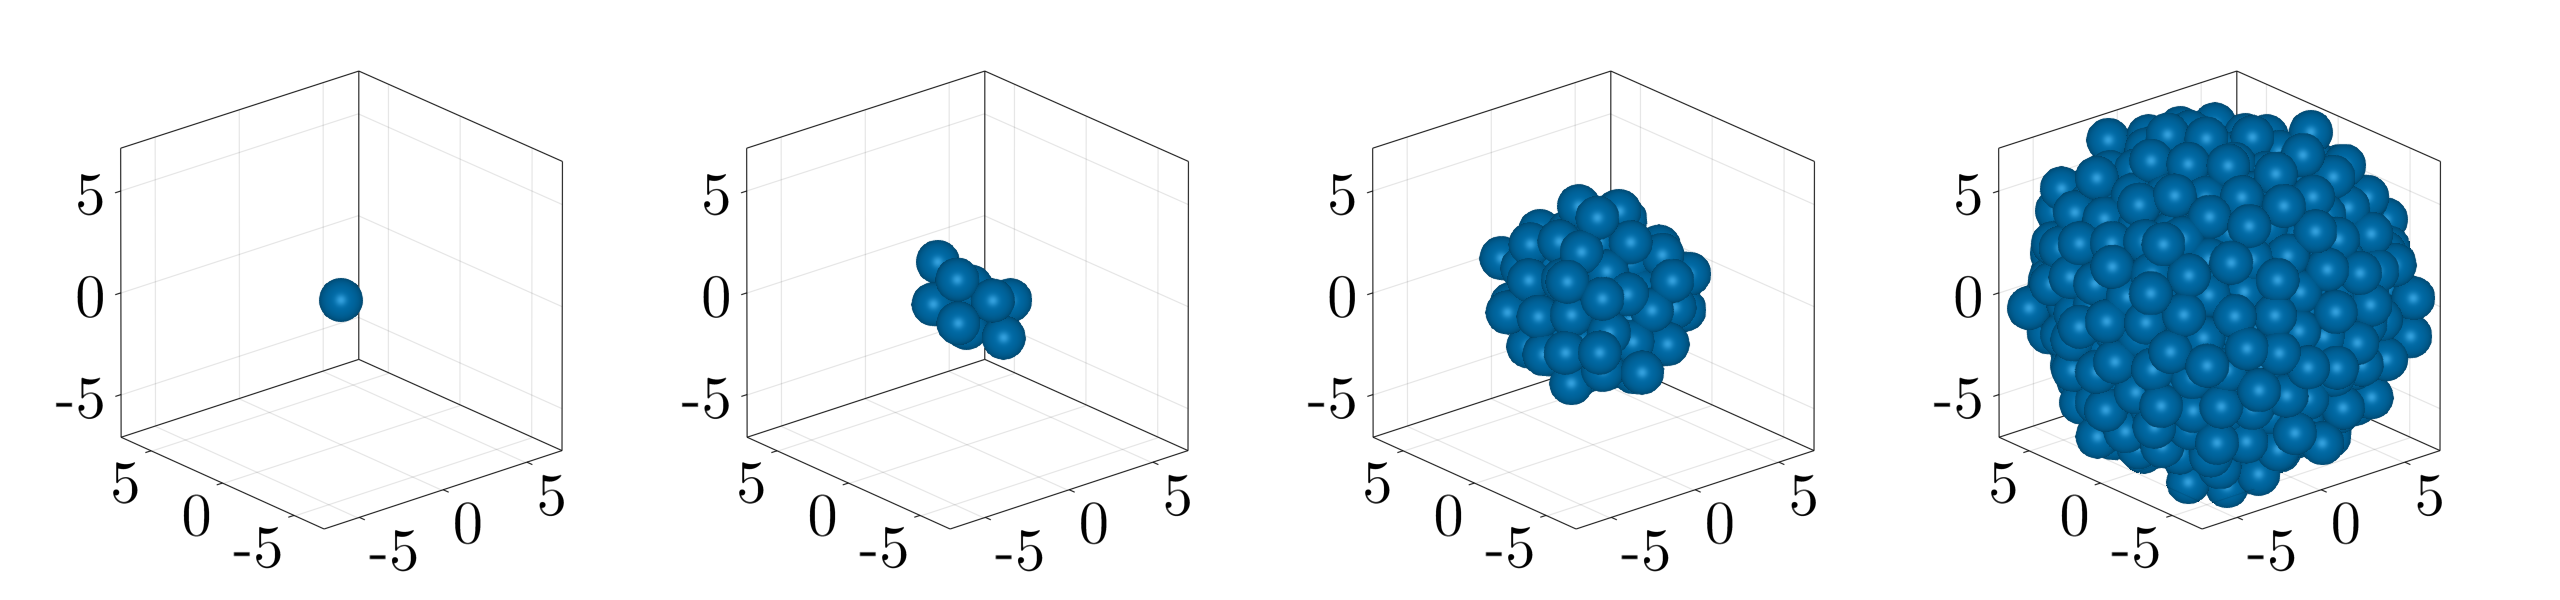

In [7]:
for i in 1:ite
	com = coms[i]
	plot_aggregate(com, color_map, 1, length(com), size  = 8.7)
end

In [ ]:
# for i in 1:ite
# 	com = coms[i]
# 	plot_aggregate_timestamps(com, color_map, length(com), size  = 8.7)
# end

## Biggest neighbourhoods

In [ ]:
function plot_aggregate_timestamps_custom(com, color_map, timestamps, j;
	size = ((maximum(com.x) - minimum(com.x)) + com.r[1]) / 1.5,
    showtitle = true,
    shownumbers = true
)

	n = length(timestamps)
	fig = Figure(resolution = (n * 640, 600), figure_padding = 40)
	labelsize = 60
	d = getParameter(com, [:x, :y, :z, :r, :cell_state])

	for (i, pos) in enumerate(timestamps)
		pos = floor(Int, pos)
		println("Plot $i: timestamp $pos")
        t = round(com[pos].t, digits=2)
		ax = Axis3(
            fig[1, i],
            aspect = :data,
            xlabel = "",
            ylabel = "",
            zlabel = "",
			xticklabelsize = labelsize,
			yticklabelsize = labelsize,
			zticklabelsize = labelsize,
            titlevisible = showtitle,
            titlealign = :center,
            titlegap = 12,
            titlesize = labelsize,
            title = L"$\alpha_{rep} = %$(reps[j])$"
        )
        if !shownumbers
            ax.xticklabelsize = 0
			ax.yticklabelsize = 0
			ax.zticklabelsize = 0
        end
		color = [color_map[j] for j in d[:cell_state][pos]]
		meshscatter!(ax, d[:x][pos], d[:y][pos], d[:z][pos], markersize = d[:r][pos], color = color) # d[:r][pos] will be constant = r
		xlims!(ax, -size, size)
		ylims!(ax, -size, size)
		zlims!(ax, -size, size)
	end

	display(fig)

end;


Least popular cell has 19 neighbours
Most popular cell has 142 neighbours, shown in the following plot.
Plot: timestamp 185


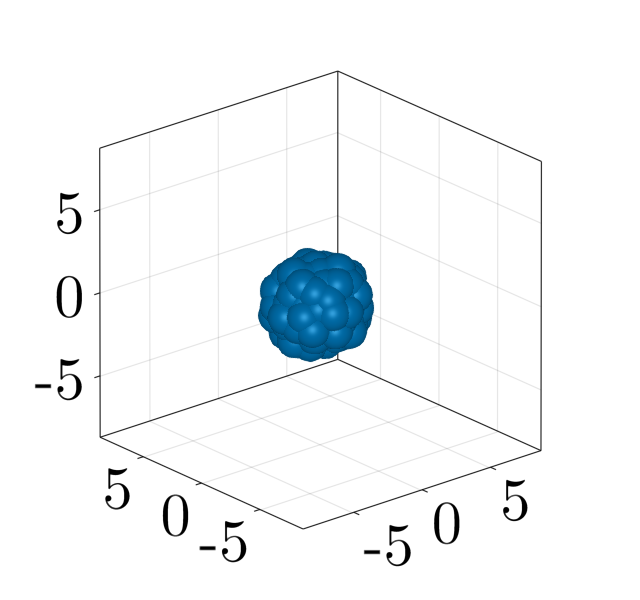

Plot 1: timestamp 185


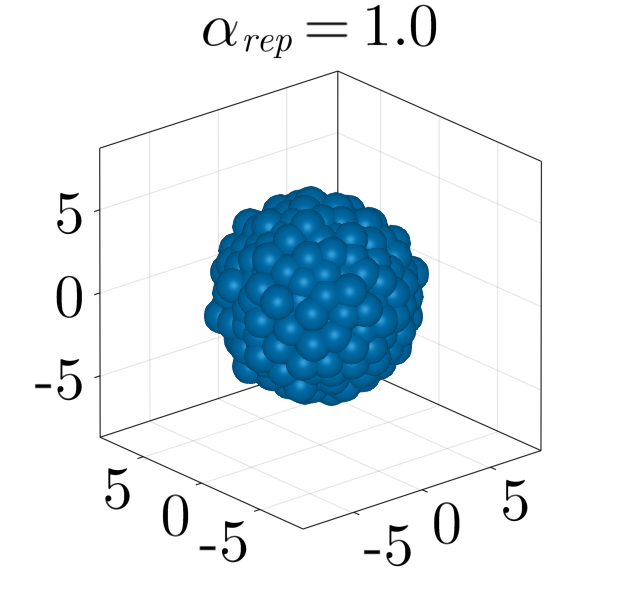

Least popular cell has 5 neighbours
Most popular cell has 45 neighbours, shown in the following plot.
Plot: timestamp 182


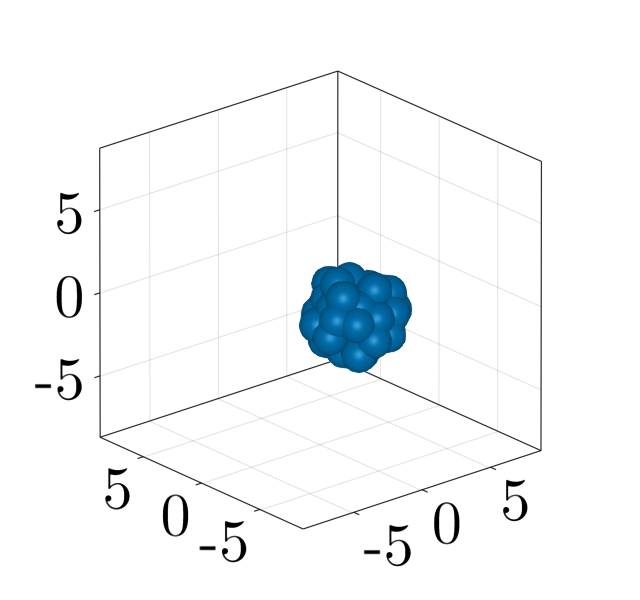

Plot 1: timestamp 182


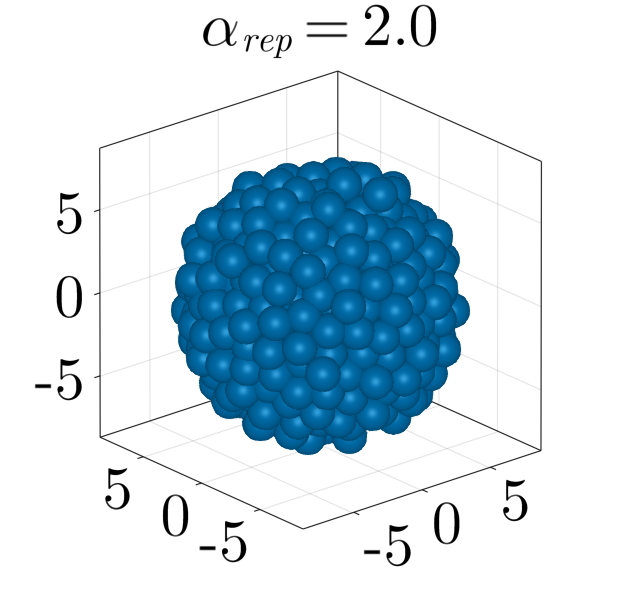

Least popular cell has 3 neighbours
Most popular cell has 30 neighbours, shown in the following plot.
Plot: timestamp 176


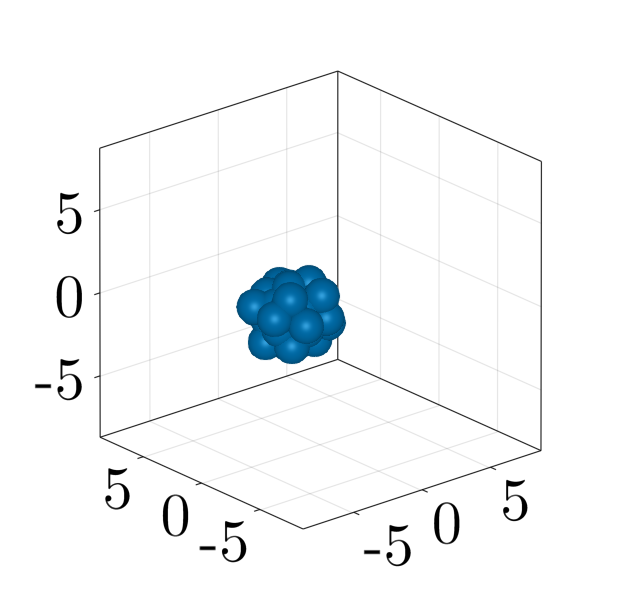

Plot 1: timestamp 176


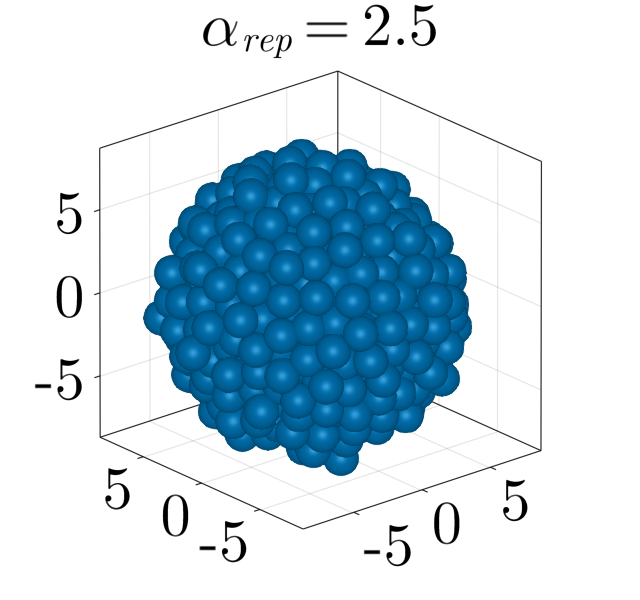

Least popular cell has 4 neighbours
Most popular cell has 25 neighbours, shown in the following plot.
Plot: timestamp 187


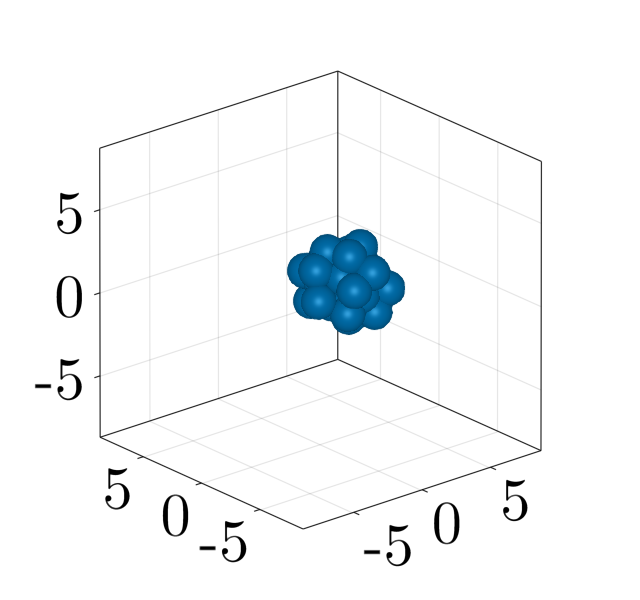

Plot 1: timestamp 187


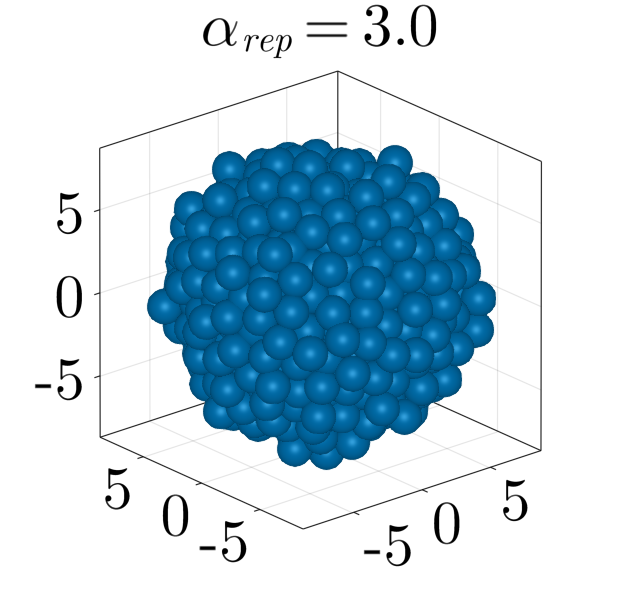

In [25]:
for i in 1:ite
	com = coms[i]
	ni = com.ni
	imax = argmax(ni)
	println("Least popular cell has $(ni[argmin(ni)]) neighbours")
	println("Most popular cell has $(ni[imax]) neighbours, shown in the following plot.")
	plot_aggregate_nbs(com, color_map, length(com), imax, size  = 8.7)
    plot_aggregate_timestamps_custom(com, color_map, length(com), i, size  = 8.7)
end


## Number of neighbours

In [52]:
for i in 1:ite
    com = coms[i]
    mean_ni = round(mean(mean(com[i].ni--) for i in 1:length(com)))
    # println(mean_ni)
    std_ni = round(std(mean(com[i].ni) for i in 1:length(com)))
    # println(std_ni)
    println("rep = $(reps[i])  ---->  $mean_ni +- $std_ni")
end

rep = 1.0  ---->  18.47 +- 19.64
rep = 2.0  ---->  9.17 +- 6.31
rep = 2.5  ---->  8.29 +- 4.9
rep = 3.0  ---->  7.16 +- 4.29


18.472748382111902


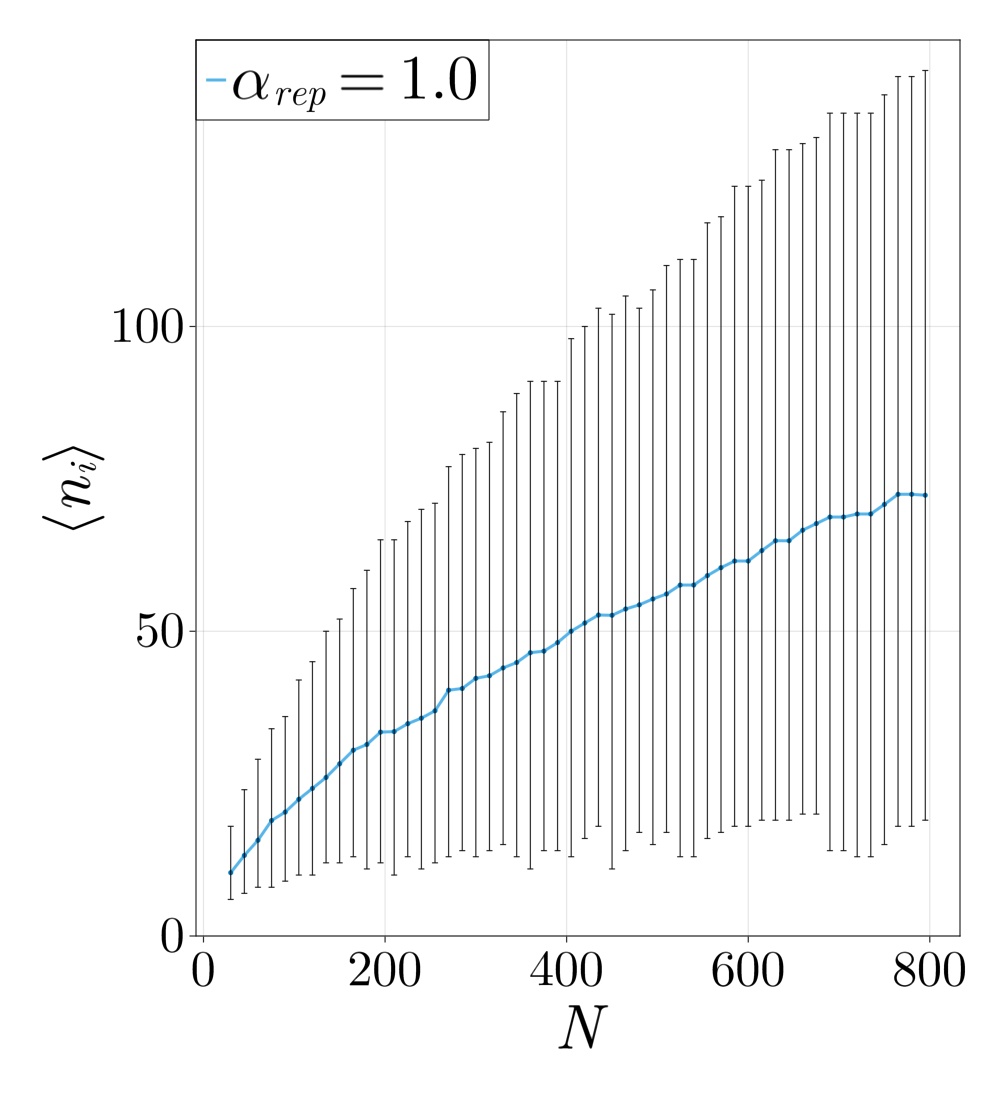

9.17150947364309


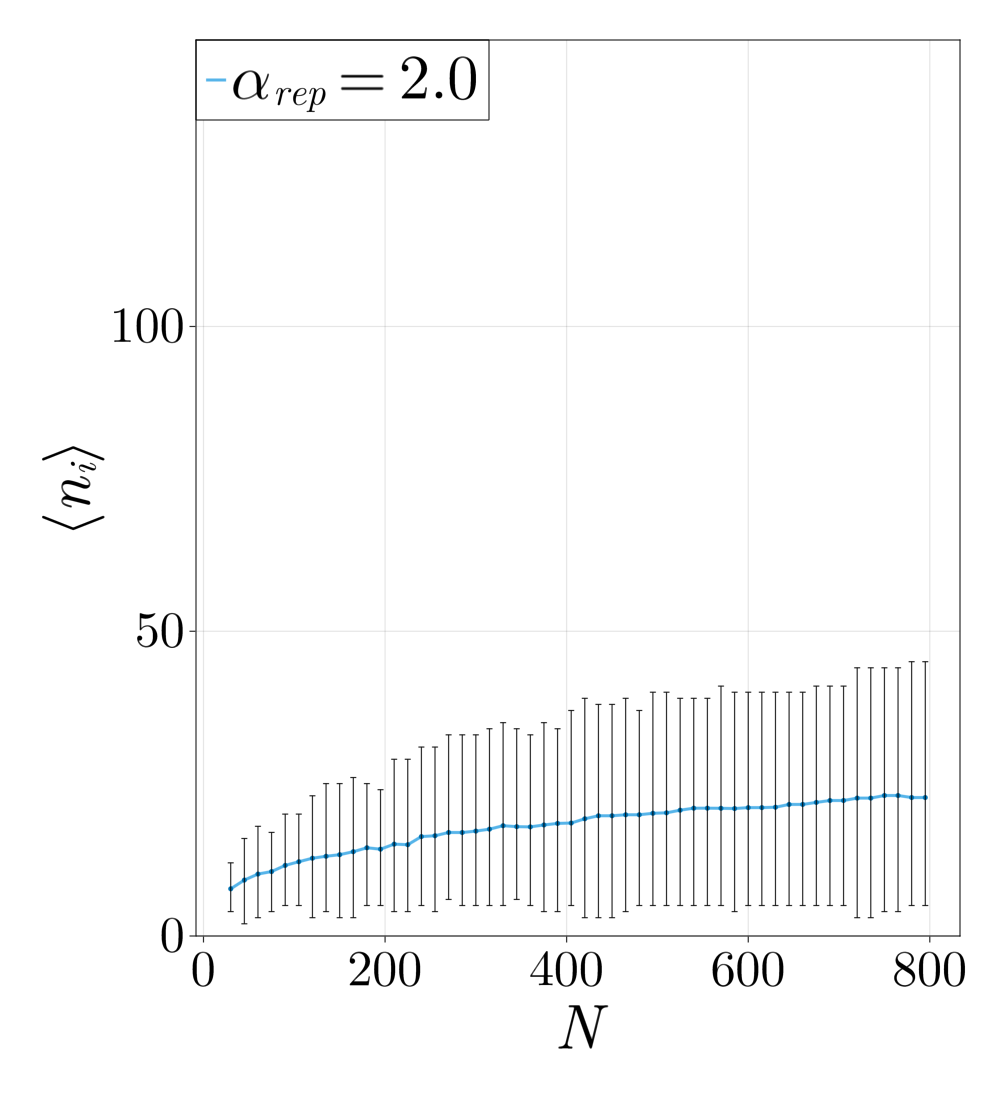

8.292703015844761


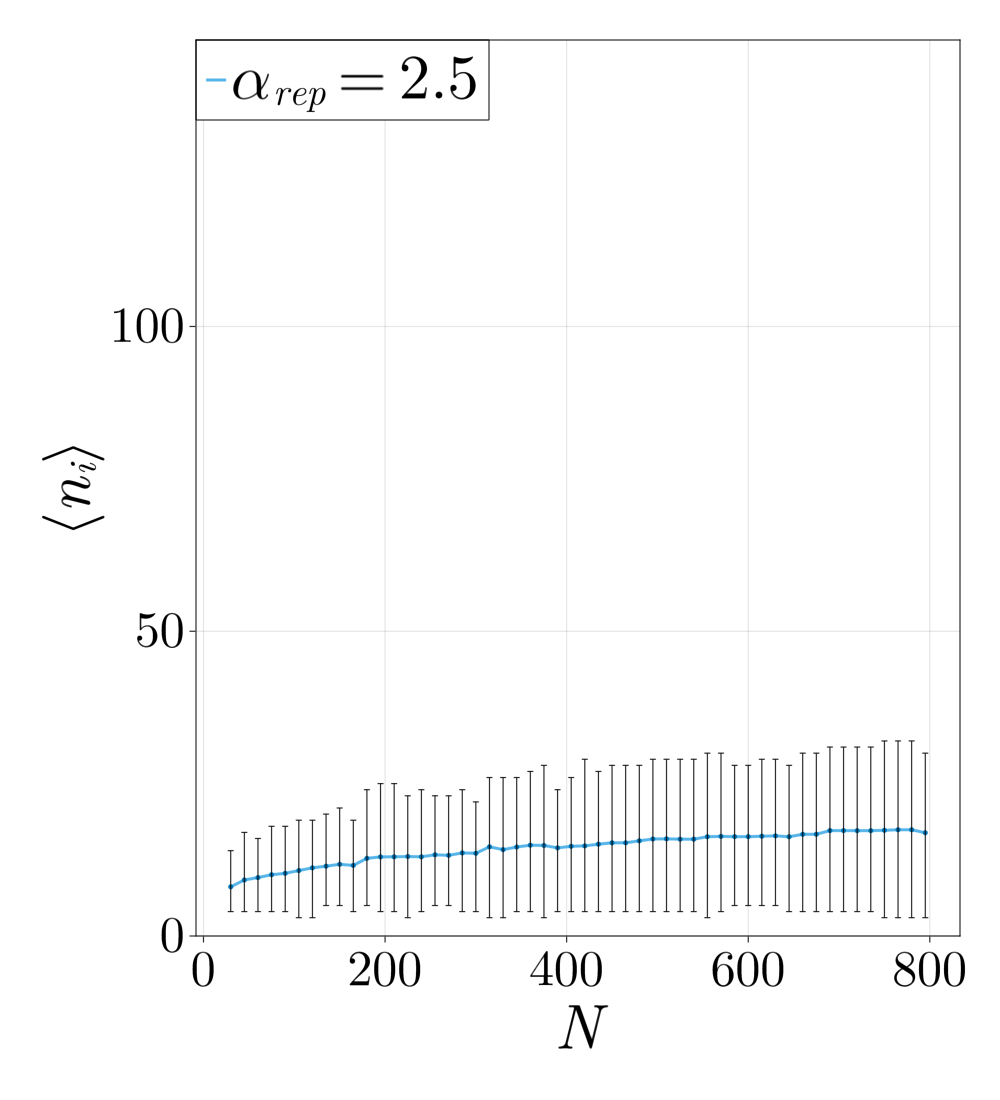

7.155347699710353


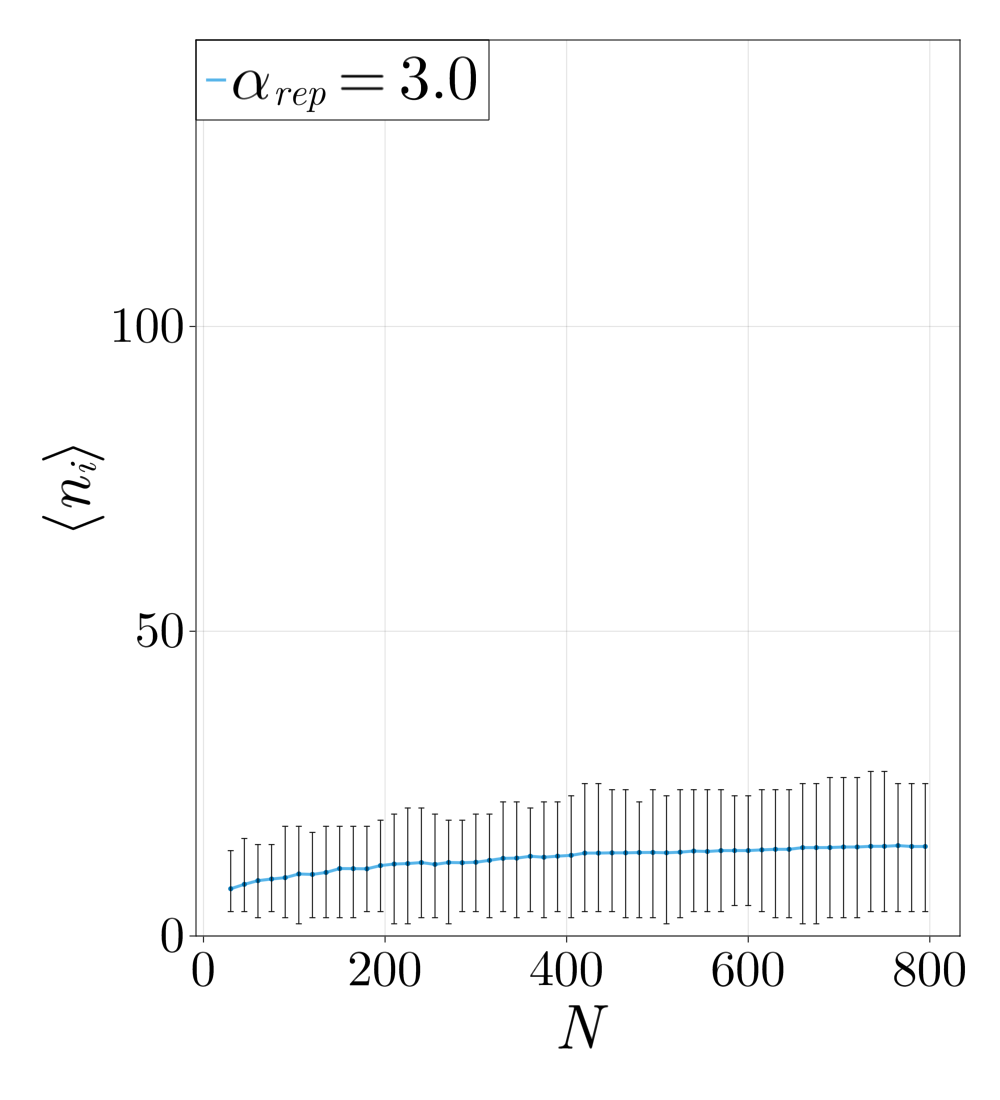

In [27]:
ylim = maximum(maximum(coms[i].ni) for i in 1:ite)

labelsize = 50
biglabelsize = 1.25 * labelsize

for i in 1:ite
	com = coms[i]

	x = (30:15:n_cells-1)
	avg_ni = [mean(com[find_instance(com, j)].ni) for j in x]
	# std_ni = [std(com[find_instance(com, j)].ni) for j in x];
	low_errors = avg_ni .- [minimum(com[find_instance(com, j)].ni) for j in x]
	high_errors = [maximum(com[find_instance(com, j)].ni) for j in x] .- avg_ni

	fig = Figure(resolution = (1000, 1100), figure_padding = 40)
	ax = Axis(
        fig[1, 1],
        xlabel = L"N", 
        ylabel = L"$\langle n_i \rangle$",
		xlabelsize = biglabelsize,
        ylabelsize = biglabelsize,
        xticklabelsize = labelsize,
        yticklabelsize = labelsize
    )
	ylims!(ax, 0, ylim + 5)

	lin = lines!(ax, x, avg_ni, color = Makie.wong_colors()[5], linewidth = 3)
	scatter!(ax, x, avg_ni, color = Makie.wong_colors()[1], markersize = 7)
	errorbars!(ax, x, avg_ni, low_errors, high_errors,
		color = :black, whiskerwidth = 6, linewidth = 1)

	Legend(fig[1,1], [lin], [L"$\alpha_{rep} = %$(reps[i])$"], halign = :left, valign = :top, tellheight = false, tellwidth = false, labelsize = biglabelsize)
    display(fig)
end


## Stabilization of the `rep = 3` case

In [ ]:
com_gb = deepcopy(coms[4]);

In [ ]:
initialize_diff!(com_gb, b=0);
m1_gb = length(com_gb)

# differentiate_all!(com_gb,save_each,prot=false)
# differentiate!(com_gb,save_each,40,prot=false)
differentiate!(com_gb, save_each, 30)
m2_gb = length(com_gb);

Plot 1: timestamp 188
Plot 2: timestamp 193
Plot 3: timestamp 199
Plot 4: timestamp 205


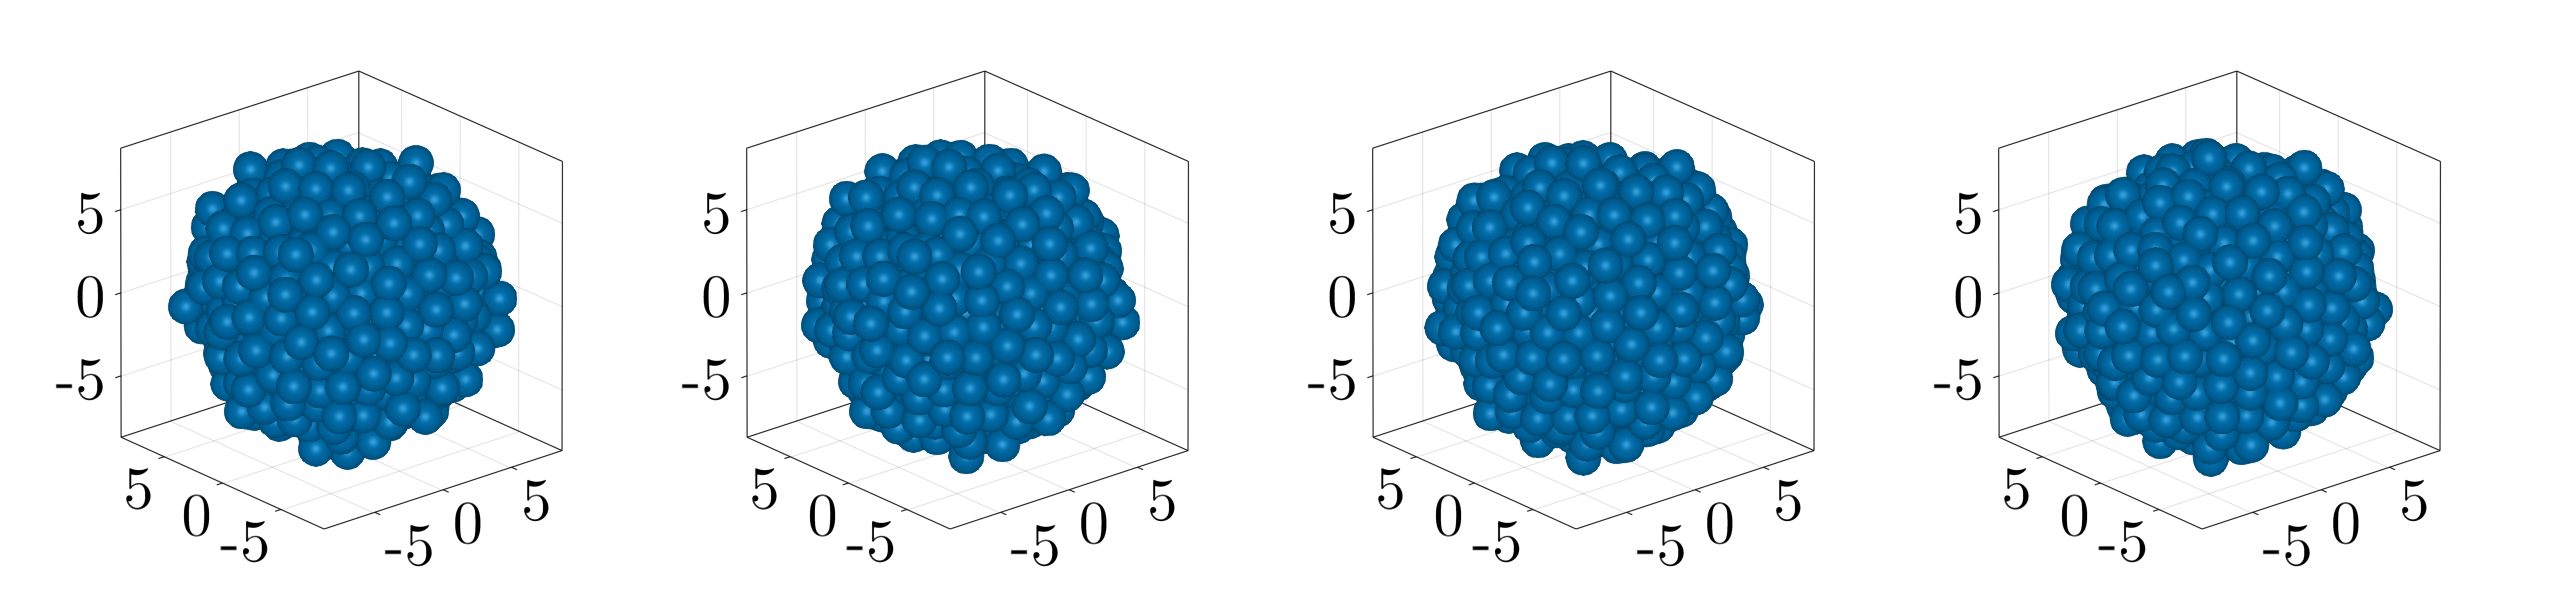

GLMakie.Screen(...)

In [69]:
plot_aggregate(com_gb, color_map, m1_gb, 205, size  = 8.7)

### Removing repulsion factor (case `rep = 1`)

In [ ]:
com_rm = deepcopy(coms[4]);

In [ ]:
initialize_diff!(com_rm, b=0)
com_rm.rep = 1
m1_rm = length(com_rm)

mechanics_evolve!(com_rm, save_each, 40)
m2_rm = length(com_rm);


Plot 1: timestamp 188
Plot 2: timestamp 202
Plot 3: timestamp 216
Plot 4: timestamp 230


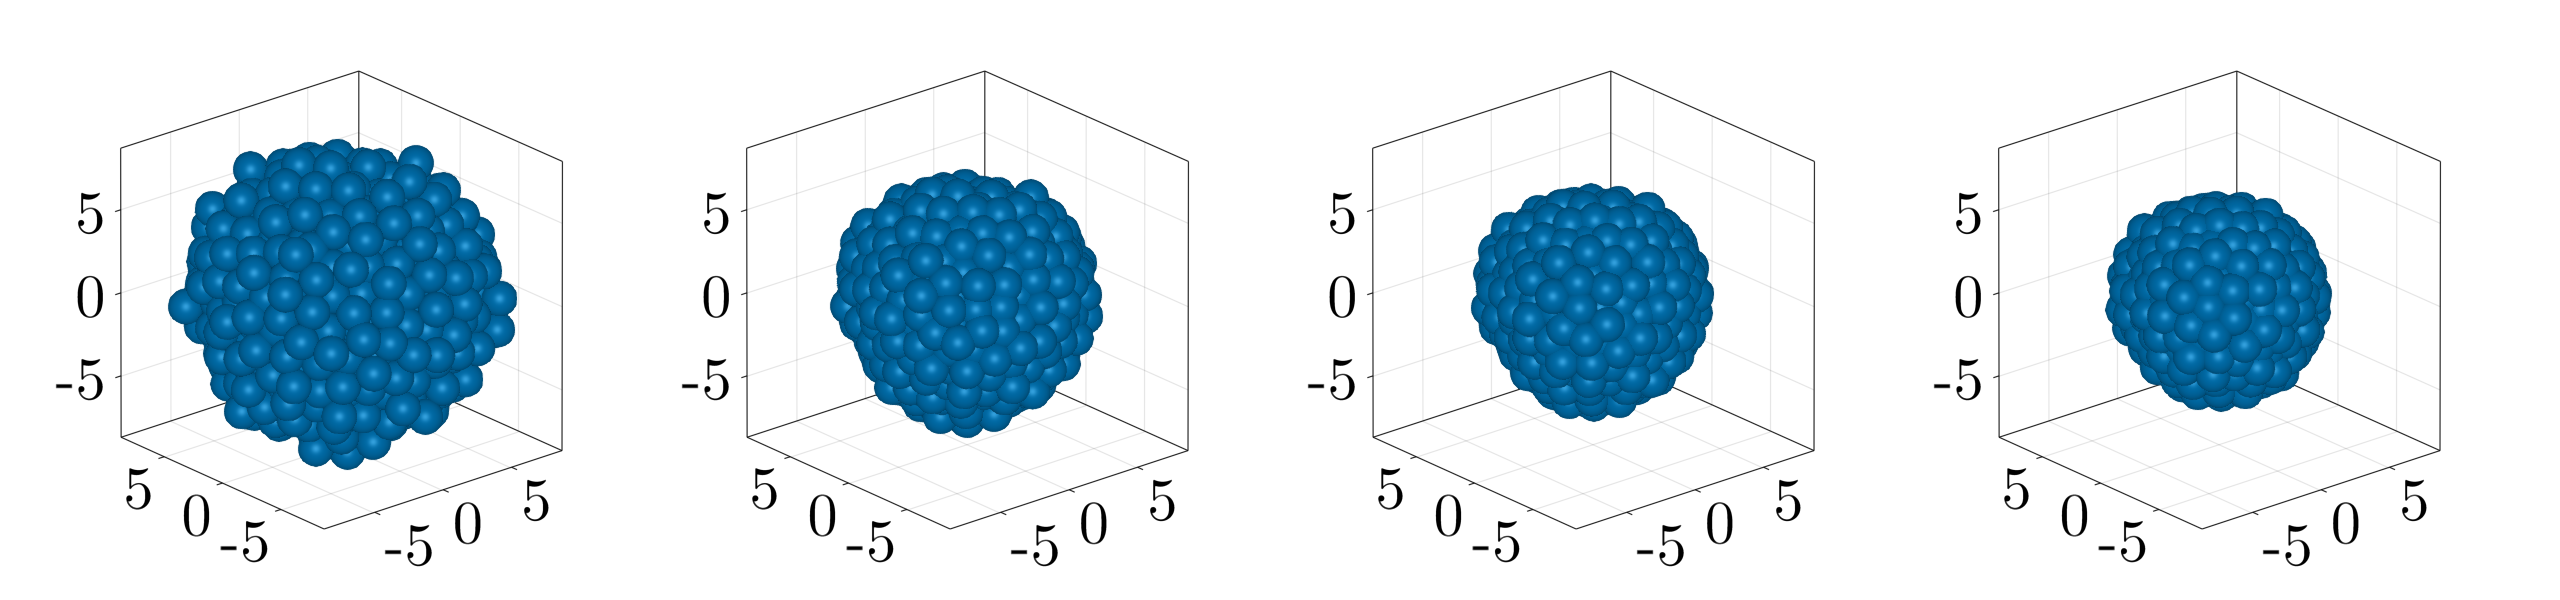

GLMakie.Screen(...)

In [67]:
plot_aggregate(com_rm, color_map, m1_rm, 230, size  = 8.7)

In [ ]:
dimensionalize_com!(com_rm)

Plot 1: timestamp 188
Plot 2: timestamp 202
Plot 3: timestamp 216
Plot 4: timestamp 230


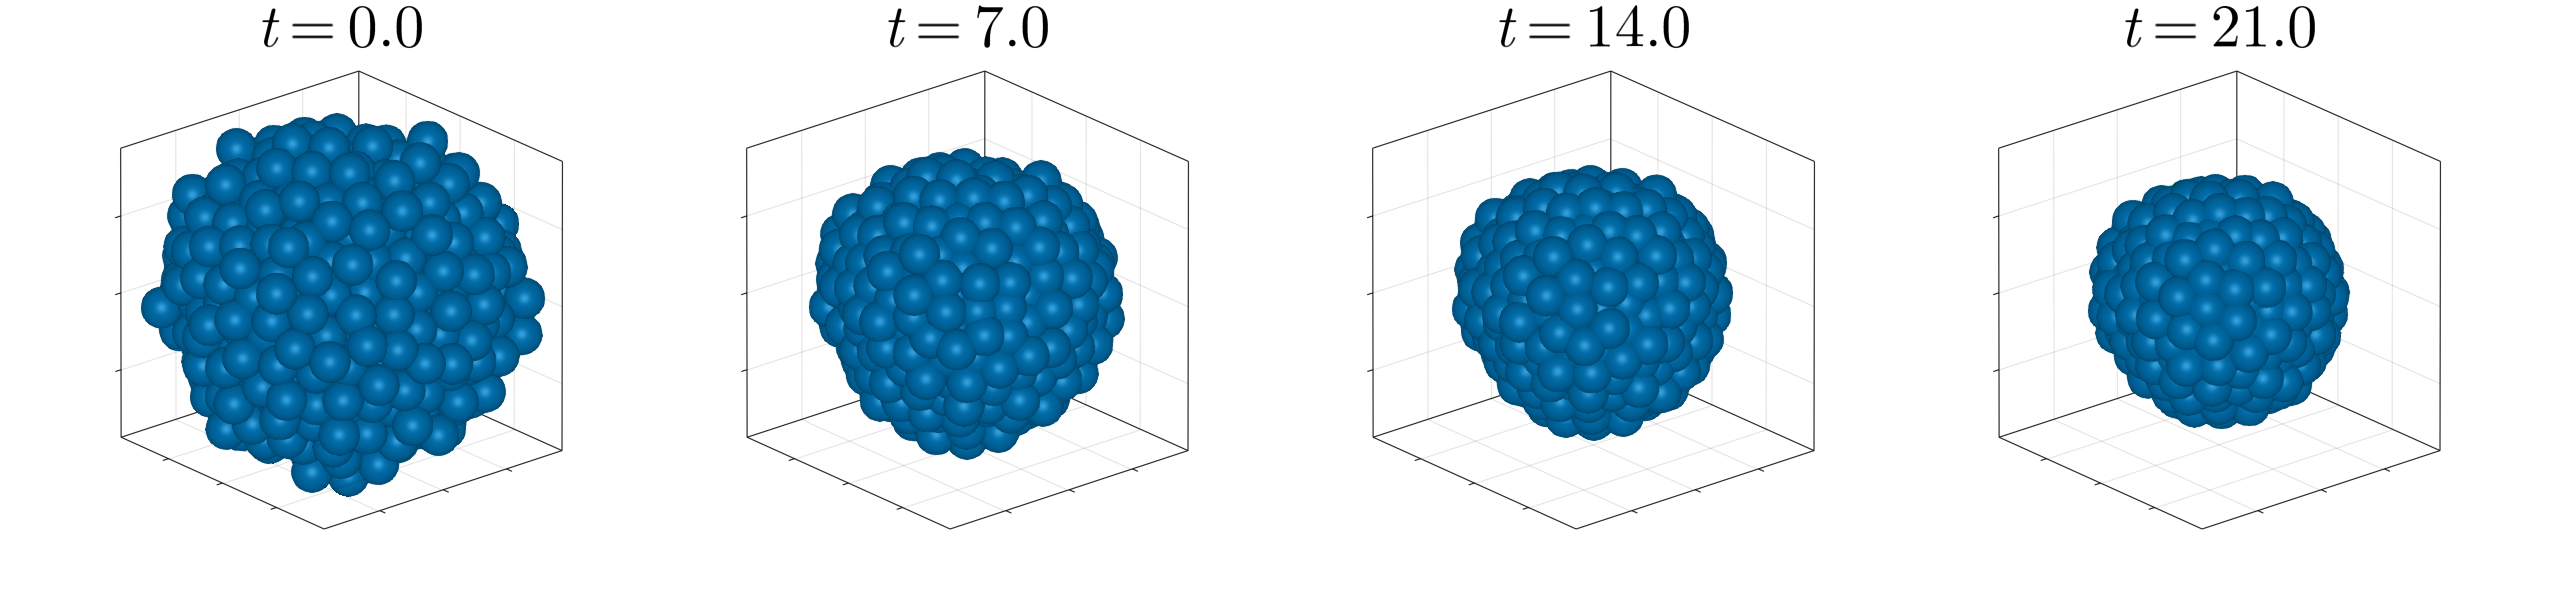

GLMakie.Screen(...)

In [73]:
plot_aggregate(com_rm, color_map, m1_rm, 230, showtime=true, shownumbers=false)